# Stage 1.5: Target Creation & Smoothing

## Pipeline Overview
```
stage1_features.parquet → [THIS NOTEBOOK] → stage1_5_targets.parquet
```

## Input
- **File**: `data/processed/stage1_features.parquet` (from Stage 1)

## Output
- **File**: `data/processed/stage1_5_targets.parquet`
- **Contents**: Features + multiple target types
- **Metadata**: `outputs/stage1_5_target_metadata.json`

## Target Types Created
1. **Raw Returns**: 1-day, 5-day, 21-day forward returns
2. **Smoothed Returns**: EMA-smoothed to reduce noise
3. **Ternary Targets**: Up(1) / Neutral(0) / Down(-1)
4. **Probability Targets**: Continuous [0,1] confidence scores
5. **Risk-Adjusted**: Sharpe-like forward targets

## Key Considerations
- Smooth targets reduce turnover noise
- Ternary targets handle uncertain middle region
- Probability scores allow confidence-weighted positions

---

In [1]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Import pipeline config
import sys
sys.path.insert(0, str(Path.cwd()))
from pipeline_config import *

print_stage_header("Target Creation & Smoothing", "1.5")
print(f"Input: {FEATURES_PARQUET}")
print(f"Output: {TARGETS_PARQUET}")

STAGE 1.5: TARGET CREATION & SMOOTHING

Input: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_features.parquet
Output: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_5_targets.parquet


## 1.5.1 Load Stage 1 Output

In [2]:
# ============================================================================
# LOAD STAGE 1 OUTPUT
# ============================================================================
print("Loading Stage 1 features...\n")

if not FEATURES_PARQUET.exists():
    raise FileNotFoundError(f"Stage 1 output not found: {FEATURES_PARQUET}\nPlease run Stage 1 first!")

df = pd.read_parquet(FEATURES_PARQUET)
df['date'] = pd.to_datetime(df['date'])

print(f"📊 Loaded Data Summary:")
print(f"   Total rows: {len(df):,}")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   Tickers: {df['ticker'].nunique()}")
print(f"   Columns: {len(df.columns)}")

# Load metadata
with open(FEATURE_METADATA_JSON, 'r') as f:
    feature_meta = json.load(f)
zscore_features = feature_meta['features']['zscore']
print(f"   Z-scored features: {len(zscore_features)}")

Loading Stage 1 features...

📊 Loaded Data Summary:
   Total rows: 241,700
   Date range: 2016-06-08 00:00:00 to 2026-01-16 00:00:00
   Tickers: 100
   Columns: 49
   Z-scored features: 38


## 1.5.2 Raw Forward Returns

In [3]:
# ============================================================================
# RAW FORWARD RETURNS
# ============================================================================
print("Computing raw forward returns...\n")

# Sort data
df = df.sort_values(['ticker', 'date'])

# Multiple horizons
for horizon in TARGET_HORIZONS:
    col = f'fwd_ret_{horizon}d'
    df[col] = df.groupby('ticker')['Close'].transform(
        lambda x: x.shift(-horizon) / x - 1
    )
    
    valid = df[col].dropna()
    print(f"   {col}: mean={valid.mean():.6f}, std={valid.std():.4f}")

# Primary target: 1-day forward return
df['target_raw'] = df['fwd_ret_1d']

print(f"\n📊 Raw Target Distribution:")
print(df['target_raw'].describe())

Computing raw forward returns...

   fwd_ret_1d: mean=0.000763, std=0.0189
   fwd_ret_5d: mean=0.003788, std=0.0410
   fwd_ret_21d: mean=0.015814, std=0.0823

📊 Raw Target Distribution:
count    241600.000000
mean          0.000763
std           0.018949
min          -0.351166
25%          -0.007479
50%           0.000791
75%           0.009132
max           0.612184
Name: target_raw, dtype: float64


## 1.5.3 Smoothed Targets (EMA)

In [4]:
# ============================================================================
# SMOOTHED TARGETS (Reduce Noise & Turnover)
# ============================================================================
print("Computing smoothed targets...\n")

# EMA smoothing of forward returns (reduces noise)
for window in [3, 5, 10]:
    col = f'target_smooth_{window}d'
    
    # Smooth the forward return signal
    df[col] = df.groupby('ticker')['fwd_ret_1d'].transform(
        lambda x: x.ewm(span=window, adjust=False).mean()
    )
    
    valid = df[col].dropna()
    print(f"   {col}: mean={valid.mean():.6f}, std={valid.std():.4f}")

# Primary smooth target (5-day EMA)
df['target_smooth'] = df['target_smooth_5d']

# Also create a "direction-consistent" smooth target
# This averages multiple horizon returns for more stable direction
df['target_multi_horizon'] = (
    df['fwd_ret_1d'] * 0.5 + 
    df['fwd_ret_5d'] * 0.3 + 
    df['fwd_ret_21d'] * 0.2
)

print(f"\n📊 Multi-horizon target correlation with 1d return: {df['target_multi_horizon'].corr(df['fwd_ret_1d']):.4f}")

Computing smoothed targets...

   target_smooth_3d: mean=0.000762, std=0.0107
   target_smooth_5d: mean=0.000761, std=0.0082
   target_smooth_10d: mean=0.000758, std=0.0057

📊 Multi-horizon target correlation with 1d return: 0.6220


## 1.5.4 Ternary Targets (Up/Neutral/Down)

In [5]:
# ============================================================================
# TERNARY TARGETS
# ============================================================================
print("Computing ternary targets...\n")

def create_ternary_target(returns, up_thresh=0.6, down_thresh=0.4):
    """
    Create ternary target based on percentile thresholds.
    Returns: 1 (Up), 0 (Neutral), -1 (Down)
    """
    pct = returns.rank(pct=True)
    target = pd.Series(0, index=returns.index)  # Neutral
    target[pct >= up_thresh] = 1   # Up
    target[pct <= down_thresh] = -1  # Down
    return target

# Cross-sectional ternary (daily ranking)
df['target_ternary'] = df.groupby('date')['fwd_ret_1d'].transform(
    lambda x: create_ternary_target(x, TERNARY_UP_THRESHOLD, TERNARY_DOWN_THRESHOLD)
)

print(f"📊 Ternary Target Distribution:")
print(df['target_ternary'].value_counts().sort_index())
print(f"\n   Up (1): {(df['target_ternary'] == 1).mean()*100:.1f}%")
print(f"   Neutral (0): {(df['target_ternary'] == 0).mean()*100:.1f}%")
print(f"   Down (-1): {(df['target_ternary'] == -1).mean()*100:.1f}%")

# Also create with different thresholds for comparison
for up_pct, down_pct in [(0.7, 0.3), (0.55, 0.45)]:
    col = f'target_ternary_{int(up_pct*100)}_{int((1-up_pct)*100)}'
    df[col] = df.groupby('date')['fwd_ret_1d'].transform(
        lambda x: create_ternary_target(x, up_pct, down_pct)
    )
    print(f"\n   {col}: Up={((df[col] == 1).mean()*100):.1f}%, Down={((df[col] == -1).mean()*100):.1f}%")

Computing ternary targets...

📊 Ternary Target Distribution:
target_ternary
-1    96636
 0    46011
 1    99053
Name: count, dtype: int64

   Up (1): 41.0%
   Neutral (0): 19.0%
   Down (-1): 40.0%

   target_ternary_70_30: Up=31.0%, Down=30.0%

   target_ternary_55_44: Up=46.0%, Down=45.0%


## 1.5.5 Probability/Confidence Targets

In [6]:
# ============================================================================
# PROBABILITY / CONFIDENCE TARGETS
# ============================================================================
print("Computing probability/confidence targets...\n")

# Method 1: Percentile-based (ranks returns as probabilities)
df['target_prob_pct'] = df.groupby('date')['fwd_ret_1d'].transform(
    lambda x: x.rank(pct=True)
)

# Method 2: Z-score to probability (normal CDF)
from scipy.stats import norm

df['target_zscore'] = df.groupby('date')['fwd_ret_1d'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-10)
)
df['target_prob_norm'] = df['target_zscore'].apply(norm.cdf)

# Method 3: Confidence-weighted by volatility regime
# Lower confidence in high-vol regimes
df['vol_confidence'] = 1 - df.groupby('date')['vol_21d_zscore'].transform(
    lambda x: x.clip(0, 2) / 2  # Scale to 0-1
)
df['target_prob_weighted'] = df['target_prob_pct'] * df['vol_confidence'].fillna(0.5)

print(f"📊 Probability Target Statistics:")
print(f"   target_prob_pct: [{df['target_prob_pct'].min():.3f}, {df['target_prob_pct'].max():.3f}]")
print(f"   target_prob_norm: [{df['target_prob_norm'].min():.3f}, {df['target_prob_norm'].max():.3f}]")
print(f"   target_prob_weighted: [{df['target_prob_weighted'].min():.3f}, {df['target_prob_weighted'].max():.3f}]")

Computing probability/confidence targets...

📊 Probability Target Statistics:
   target_prob_pct: [0.010, 1.000]
   target_prob_norm: [0.000, 1.000]
   target_prob_weighted: [0.000, 1.000]


## 1.5.6 Risk-Adjusted Targets

In [7]:
# ============================================================================
# RISK-ADJUSTED TARGETS
# ============================================================================
print("Computing risk-adjusted targets...\n")

# Forward Sharpe-like target (return / vol)
# Use trailing volatility as risk measure
df['target_risk_adj'] = df['fwd_ret_1d'] / (df['vol_21d_zscore'].abs() + 0.01)

# Winsorize extreme values
df['target_risk_adj'] = df['target_risk_adj'].clip(
    df['target_risk_adj'].quantile(0.01),
    df['target_risk_adj'].quantile(0.99)
)

# Cross-sectional z-score the risk-adjusted target
df['target_risk_adj_zscore'] = df.groupby('date')['target_risk_adj'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-10)
)

print(f"📊 Risk-Adjusted Target Statistics:")
print(df['target_risk_adj_zscore'].describe())

Computing risk-adjusted targets...

📊 Risk-Adjusted Target Statistics:
count    2.416000e+05
mean     9.411162e-19
std      9.949895e-01
min     -8.340825e+00
25%     -3.032559e-01
50%     -2.674421e-02
75%      2.678638e-01
max      8.760237e+00
Name: target_risk_adj_zscore, dtype: float64


## 1.5.7 Target Diagnostics & Comparison

In [11]:
# ============================================================================
# TARGET DIAGNOSTICS
# ============================================================================
print("Running target diagnostics...\n")

target_cols = [
    'target_raw', 'target_smooth', 'target_multi_horizon',
    'target_ternary', 'target_prob_pct', 'target_risk_adj_zscore'
]

# Calculate turnover for each target (how much it changes day-to-day)
print("📊 Target Turnover Analysis (lower = more stable):")
turnover_results = []

for col in target_cols:
    if col == 'target_ternary':
        # For ternary, count percentage of changes
        changes = df.groupby('ticker')[col].apply(
            lambda x: (x != x.shift(1)).mean()
        )
        turnover = changes.mean() * 100
    else:
        # For continuous, use mean absolute change
        changes = df.groupby('ticker')[col].apply(
            lambda x: x.diff().abs().mean()
        )
        turnover = changes.mean()
    
    turnover_results.append({'target': col, 'turnover': turnover})
    print(f"   {col}: {turnover:.4f}")

turnover_df = pd.DataFrame(turnover_results)

Running target diagnostics...

📊 Target Turnover Analysis (lower = more stable):
   target_raw: 0.0181
   target_smooth: 0.0046
   target_multi_horizon: 0.0151
   target_ternary: 63.6115
   target_prob_pct: 0.3305
   target_risk_adj_zscore: 0.7795



📊 Target Correlation Matrix:


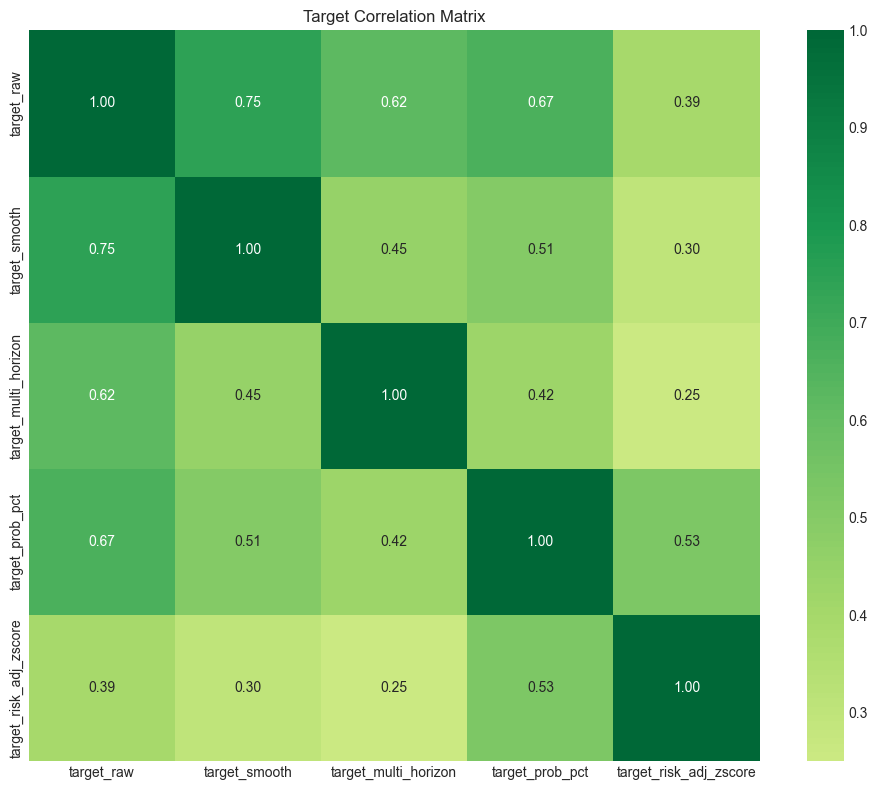

In [12]:
# ============================================================================
# TARGET CORRELATION MATRIX
# ============================================================================
print("\n📊 Target Correlation Matrix:")

# Create correlation matrix for continuous targets
continuous_targets = ['target_raw', 'target_smooth', 'target_multi_horizon', 
                      'target_prob_pct', 'target_risk_adj_zscore']

corr_matrix = df[continuous_targets].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, ax=ax)
ax.set_title('Target Correlation Matrix')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'stage1_5_target_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# ============================================================================
# FEATURE-TARGET IC COMPARISON
# ============================================================================
print("\n📊 Feature IC Comparison Across Targets:")

# Select top features
top_features = ['mom_21d_zscore', 'vol_21d_zscore', 'rsi_14d_zscore', 
                'kalman_momentum_zscore', 'bb_position_zscore']
top_features = [f for f in top_features if f in df.columns]

ic_comparison = []

for target in ['target_raw', 'target_smooth', 'target_prob_pct']:
    for feat in top_features:
        valid = df[[feat, target, 'date']].dropna()
        daily_ic = valid.groupby('date').apply(
            lambda g: spearmanr(g[feat], g[target])[0] if len(g) > 5 else np.nan
        )
        ic_comparison.append({
            'feature': feat,
            'target': target,
            'mean_ic': daily_ic.mean(),
            'ic_ir': daily_ic.mean() / (daily_ic.std() + 1e-10)
        })

ic_comp_df = pd.DataFrame(ic_comparison)
ic_pivot = ic_comp_df.pivot(index='feature', columns='target', values='mean_ic')
print(ic_pivot.round(4))


📊 Feature IC Comparison Across Targets:
target                  target_prob_pct  target_raw  target_smooth
feature                                                           
bb_position_zscore              -0.0048     -0.0048         0.5030
kalman_momentum_zscore          -0.0072     -0.0072         0.4613
mom_21d_zscore                  -0.0063     -0.0063         0.3032
rsi_14d_zscore                  -0.0050     -0.0050         0.5258
vol_21d_zscore                   0.0039      0.0039         0.0250


## 1.5.8 Export Targets

In [13]:
# ============================================================================
# SAVE OUTPUTS
# ============================================================================
print("Saving outputs...\n")

# All target columns
all_targets = [
    'fwd_ret_1d', 'fwd_ret_5d', 'fwd_ret_21d',
    'target_raw', 'target_smooth', 'target_smooth_3d', 'target_smooth_5d', 'target_smooth_10d',
    'target_multi_horizon',
    'target_ternary', 'target_ternary_70_30', 'target_ternary_55_45',
    'target_prob_pct', 'target_prob_norm', 'target_prob_weighted',
    'target_zscore', 'target_risk_adj', 'target_risk_adj_zscore'
]
all_targets = [t for t in all_targets if t in df.columns]

# Original features + targets
base_cols = ['date', 'ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 
             'returns', 'vol_regime', 'trend_regime']
export_cols = base_cols + zscore_features + all_targets

# Save parquet
df[export_cols].to_parquet(TARGETS_PARQUET, index=False)
print(f"✅ Saved to: {TARGETS_PARQUET}")

# Save metadata
metadata = {
    'created_at': pd.Timestamp.now().isoformat(),
    'input_file': str(FEATURES_PARQUET),
    'n_rows': len(df),
    'targets': {
        'raw': ['fwd_ret_1d', 'fwd_ret_5d', 'fwd_ret_21d', 'target_raw'],
        'smooth': ['target_smooth', 'target_smooth_3d', 'target_smooth_5d', 'target_smooth_10d', 'target_multi_horizon'],
        'ternary': ['target_ternary', 'target_ternary_70_30', 'target_ternary_55_45'],
        'probability': ['target_prob_pct', 'target_prob_norm', 'target_prob_weighted'],
        'risk_adjusted': ['target_zscore', 'target_risk_adj', 'target_risk_adj_zscore']
    },
    'turnover_analysis': turnover_df.to_dict('records'),
    'recommended_target': 'target_smooth',
    'recommended_ternary': 'target_ternary'
}

with open(TARGET_METADATA_JSON, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved metadata to: {TARGET_METADATA_JSON}")

print("\n" + "=" * 70)
print("✅ STAGE 1.5 COMPLETE")
print("=" * 70)
print(f"\nNext: Run Stage 2 (Model Training) notebook")
print(f"Input file: {TARGETS_PARQUET}")

Saving outputs...

✅ Saved to: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_5_targets.parquet
✅ Saved metadata to: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\stage1_5_target_metadata.json

✅ STAGE 1.5 COMPLETE

Next: Run Stage 2 (Model Training) notebook
Input file: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_5_targets.parquet
